In [1]:
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

import os
import sys

from pathlib import Path

%matplotlib inline

from IPython.display import display, HTML
from weasyprint import HTML as pdf_c

/Users/roberthughes/anaconda3/lib/python3.7/site-packages/weasyprint/document.py:36: UserWarning: There are known rendering problems and missing features with cairo < 1.15.4. WeasyPrint may work with older versions, but please read the note about the needed cairo version on the "Install" page of the documentation before reporting bugs. http://weasyprint.readthedocs.io/en/latest/install.html
  'There are known rendering problems and missing features with '


In [2]:
# Name of file to import raw data from (from bloomberg)
filename = "Norepinephrine Market vRH.xlsx"

# Dynamically create filepath independent of system
path = Path(os.getcwd())
filepath = os.path.abspath(os.path.join(path.parent, "imports", filename))

# appending to sys.path to allow for relative import of general functions
sys.path.append(os.path.abspath(path.parent.parent))
from drug_curves import *

In [3]:
# Importing in data
raw_data = pd.read_excel(filepath, sheet_name="BB New", header=[0, 1, 2])
raw_data.columns = multi_index_column_rename(raw_data.columns)

# Global Important Variables
DRUGS = ["Levophed Bitartrate", "Norepinephrine Bitartrate"]
UNITS = {
    "volume": "Institutional Pack Units",
    "mbs": "Institutional Mbs"
}

# Organizing Data

In [4]:
# Examinine that all date columns match
# Note -- df.duplicated was not working for some reason
idx = pd.IndexSlice[:, :, "Date"]
assert raw_data.loc[:, idx].apply(lambda row: row.duplicated(keep=False).all(), axis=1).sum() == raw_data.shape[0]

# Assert "Date" is a timestmap/datetime dtype
assert pd.core.dtypes.common.is_datetime_or_timedelta_dtype(raw_data.loc[:, idx].iloc[:, 0])

# Push the first "Date Column"
raw_data.set_index(raw_data.loc[:, idx].iloc[:, 0], inplace=True)
raw_data.index.name = "Date"


# Dropping "Date" Columns and ["Blank"] columns [if any]
raw_data.drop("Date", axis=1, level=2, inplace=True)
for level in raw_data.columns:
    if "[Blank]" in level:
        raw_data.drop("[Blank]", axis=1, level=2, inplace=True)
        break

# Dropping rows earlier than 1/31/2013
raw_data = raw_data.loc[raw_data.index >= pd.Timestamp(year=2013, month=1, day=31), :].copy()

# Dropping empty columns
columns_to_drop = []
for column in raw_data:
    if raw_data.loc[:, column].isnull().all():
        columns_to_drop.append(column)
raw_data.drop(columns_to_drop, axis=1, inplace=True)

# Changing column names to match pricerx db
mapper = {"Pfizer/Hospira": "Pfizer",
          "Hospira/Novaplu": "Novation",
          "Amneal Bio": "Amneal",
          "Sandoz Inc": "Sandoz",
          "Sicor Pharma": "Teva",
          "Baxter/Claris": "Claris",
          "Hikma/West-Ward": "Hikma",
          "Mylan Instituti": "Mylan",
         }
raw_data.rename(mapper, axis=1, level=2, inplace=True)

# Visualizing our new modified df
raw_data.head()

Total Market                            \
           Institutional Pack Units                             
                Levophed Bitartrate Norepinephrine Bitartrate   
Date                                                            
2019-08-31                  64080.0                  678513.0   
2019-07-31                  60110.0                  667584.0   
2019-06-30                  50320.0                  604311.0   
2019-05-31                  56730.0                  719010.0   
2019-04-30                  74940.0                  693860.0   

                Levophed Bitartrate                                      \
           Institutional Pack Units          Institutional Mbs            
                             Pfizer Novation            Pfizer Novation   
Date                                                                      
2019-08-31                  64080.0      NaN         1296338.4      NaN   
2019-07-31                  60110.0      NaN         1216025.3      NaN   
2019-06-30                  50320.0      NaN         1017973.6      NaN   
2019-05-31                  56730.0      NaN         1147647.9      NaN   
2019-04-30                  74940.0      NaN         1516036.2      NaN   

           Norepinephrine Bitartrate                                        \
            Institutional Pack Units                                         
                              Amneal   Sandoz      Teva    Claris    Hikma   
Date                                                                         
2019-08-31                    1090.0  13140.0   86440.0  439843.0  41510.0   
2019-07-31                     270.0   6830.0   93840.0  442244.0  33090.0   
2019-06-30                       NaN   8560.0   87910.0  403751.0  13370.0   
2019-05-31                       NaN      NaN  111660.0  482600.0  30480.0   
2019-04-30                       NaN      NaN  106610.0  475340.0  25020.0   

                                                                         \
                    Institutional Mbs                                     
              Mylan            Amneal     Sandoz       Teva      Claris   
Date                                                                      
2019-08-31  96490.0           19641.8  239239.98  1557648.8  3848626.25   
2019-07-31  91310.0            4865.4  124353.81  1690996.8  3869635.00   
2019-06-30  90720.0               NaN  155851.92  1584138.2  3532821.25   
2019-05-31  94270.0               NaN        NaN  2012113.2  4222750.00   
2019-04-30  86890.0               NaN        NaN  1921112.2  4159225.00   

                                   
                                   
                Hikma       Mylan  
Date                               
2019-08-31  830781.14  1684618.91  
2019-07-31  662263.26  1594181.29  
2019-06-30  267587.18  1583880.48  
2019-05-31  610026.72  1645859.93  
2019-04-30  500750.28  1517012.51

# Visualizing Missing Data

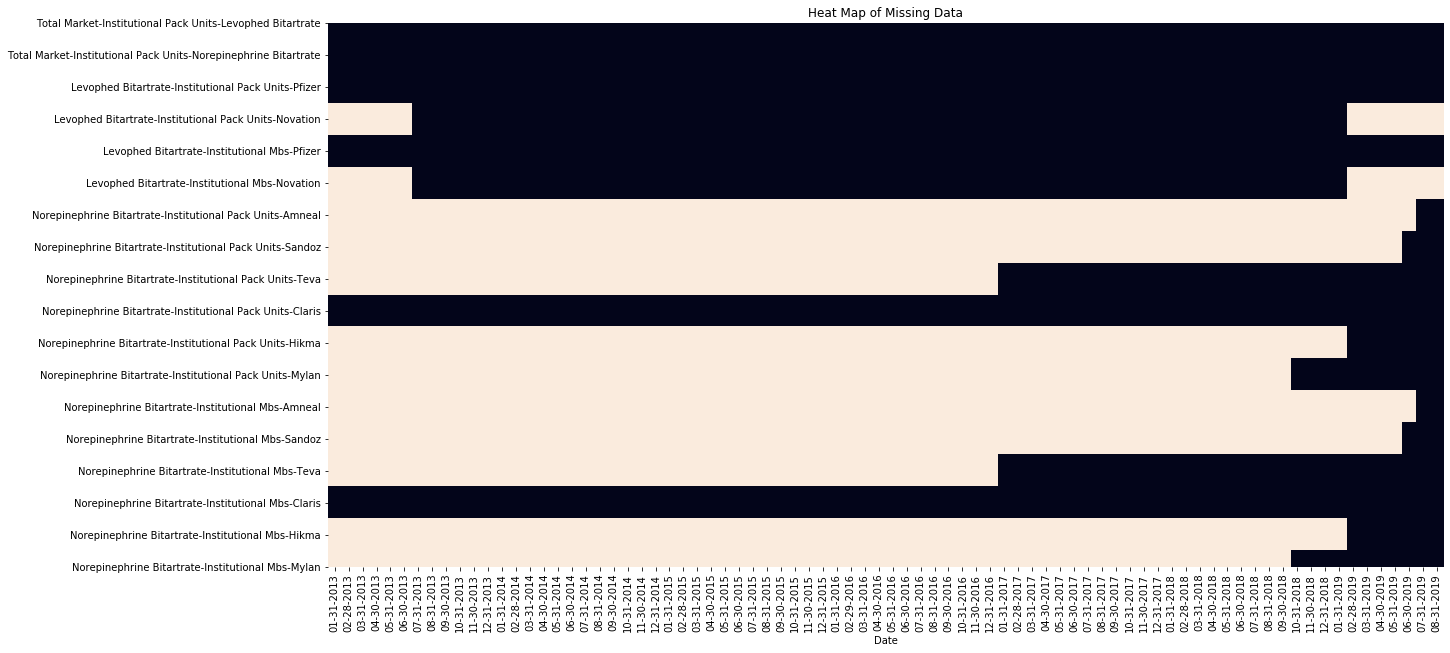

In [5]:
# Visualizing Missing Data
fig = plt.figure(figsize=(20,10))
ax = sns.heatmap(raw_data.isnull().T, cbar=False)
plt.ylabel(None)
title = plt.title("Heat Map of Missing Data")
labels = ax.set_xticklabels(np.array(raw_data.index.map(lambda date: date.strftime('%m-%d-%Y'))))
ax.invert_xaxis()

# Data Validation

In [6]:
# These assertions check that we are capturing the entire drug volume (we breakout by manuf.)
assert (raw_data.loc[:, ("Total Market", "Institutional Pack Units", DRUGS[0])]\
== raw_data.loc[:, (DRUGS[0], "Institutional Pack Units", slice(None))].sum(axis=1)).all()

assert (raw_data.loc[:, ("Total Market", "Institutional Pack Units", DRUGS[1])]\
== raw_data.loc[:, (DRUGS[1], "Institutional Pack Units", slice(None))].sum(axis=1)).all()

# Replacing negative numbers with 0s
raw_data.mask(raw_data < 0, 0, inplace=True)

In [7]:
pricerx_df = pricerx_df_gen(DRUGS)
frames = {}
calculated_df = pd.DataFrame()
report = pd.DataFrame()

for drug in DRUGS:
    all_manufacturers = raw_data.loc[:, drug]
    frames[drug] = {}
    for manufacturer in all_manufacturers.columns.get_level_values(1).unique():
        idx = pd.IndexSlice[:, manufacturer]
        manufacturer_df = all_manufacturers.loc[:, idx].copy()
        manufacturer_df.columns = manufacturer_df.columns.droplevel(level=1)
        manufacturer_df["Drug"] = drug
        manufacturer_df["Manufacturer"] = manufacturer
        
        manufacturer_pricerx = pricerx_df.loc[(pricerx_df["Drug"] == drug) & (pricerx_df["Manufacturer"] == manufacturer), :].copy()
        
        manufacturer_df["Price/Vial"] = (manufacturer_pricerx["Price"] / manufacturer_pricerx["Package"]).astype(float)
        manufacturer_df["Calculated Total"] = manufacturer_df[UNITS["volume"]] * manufacturer_df["Price/Vial"]
        manufacturer_df["Difference"] = round(manufacturer_df["Calculated Total"] - manufacturer_df[UNITS["mbs"]], 2)
        manufacturer_df["Percentage Change"] = round(manufacturer_df["Difference"] / manufacturer_df[UNITS["mbs"]], 2)
        
        frames[drug][manufacturer] = manufacturer_df
        calculated_df = calculated_df.append(manufacturer_df)
        
        report[("{}-{}".format(drug, manufacturer))] = manufacturer_df["Percentage Change"]

def color_negative_red(x):
    y = float(x[:x.find("%")])
    if y > 0 or y < 0:
        color = "red"
    else:
        color = "black"
    return 'color: {}'.format(color)

report = report.applymap(lambda val: "{:.0%}".format(val))
report.index = report.index.date
report = report.head(12).style.applymap(color_negative_red)
report

,Levophed Bitartrate-Pfizer,Levophed Bitartrate-Novation,Norepinephrine Bitartrate-Amneal,Norepinephrine Bitartrate-Sandoz,Norepinephrine Bitartrate-Teva,Norepinephrine Bitartrate-Claris,Norepinephrine Bitartrate-Hikma,Norepinephrine Bitartrate-Mylan
2019-08-31,0%,nan%,0%,0%,0%,0%,0%,0%
2019-07-31,0%,nan%,0%,0%,0%,0%,0%,0%
2019-06-30,0%,nan%,nan%,0%,0%,0%,0%,0%
2019-05-31,0%,nan%,nan%,nan%,0%,0%,0%,0%
2019-04-30,0%,nan%,nan%,nan%,0%,0%,-0%,0%
2019-03-31,0%,nan%,nan%,nan%,0%,0%,0%,0%
2019-02-28,0%,nan%,nan%,nan%,0%,0%,nan%,-0%
2019-01-31,0%,nan%,nan%,nan%,-0%,0%,nan%,0%
2018-12-31,0%,nan%,nan%,nan%,0%,0%,nan%,0%
2018-11-30,0%,nan%,nan%,nan%,0%,0%,nan%,0%


In [8]:
calculated_df.head()

,Institutional Pack Units,Institutional Mbs,Drug,Manufacturer,Price/Vial,Calculated Total,Difference,Percentage Change
Date,,,,,,,,
2019-08-31,64080.0,1296338.4,Levophed Bitartrate,Pfizer,20.23,1296338.4,0.0,0.0
2019-07-31,60110.0,1216025.3,Levophed Bitartrate,Pfizer,20.23,1216025.3,0.0,0.0
2019-06-30,50320.0,1017973.6,Levophed Bitartrate,Pfizer,20.23,1017973.6,0.0,0.0
2019-05-31,56730.0,1147647.9,Levophed Bitartrate,Pfizer,20.23,1147647.9,0.0,0.0
2019-04-30,74940.0,1516036.2,Levophed Bitartrate,Pfizer,20.23,1516036.2,0.0,0.0


# Report

## Set up

In [9]:
# Creating Report
r = Report(calculated_df, "Norepinephrine U.S. Market")

# Imported colors from plotting_formatting
COLORS = plt_color_conversion(color_map_universal)

# Color Map (for Nor Curve)
nor_plotting_map = {
    "Levophed Bitartrate": {
        "Pfizer": {"color": COLORS["blue"]},
        "Novation": {"color" : COLORS["orange"]},
    },
    "Norepinephrine Bitartrate": {
        "Hikma": {"color": COLORS["grey"]},
        "Amneal": {"color": COLORS["blue-grey"]},
        "Claris": {"color": COLORS["green"]},
        "Sandoz": {"color": COLORS["red"]},
        "Teva": {"color": COLORS["yellow"]},
        "Mylan": {"color": COLORS["purple"]},
    },
    "Total": {"color": COLORS["purple"]},
}

# Adding a label key (imported function)
add_label_key(nor_plotting_map)

# Registering pd.Timestamp conversions for plotting
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Globally setting the linewidth
matplotlib.rcParams['lines.linewidth'] = 3
matplotlib.rcParams['font.family'] = "Open Sans"
matplotlib.rcParams['text.color'] = COLORS["black"]
matplotlib.rcParams['axes.labelcolor'] = COLORS["black"]
matplotlib.rcParams['xtick.color'] = COLORS["black"]
matplotlib.rcParams['ytick.color'] = COLORS["black"]

# Globally configuring resolution on images
matplotlib.rcParams["figure.dpi"] = 450

title_keywords = {
    "size": 16,
    "position": (.45, 1),
}
price_title_keywords = {
    "size": 16,
    "position": (.49, 1),
}
xlabel_keywords = {
    "labelpad": 40,
    "position": (.45, 1),
    "size": "medium",
}
ylabel_keywords = {
    "size": "large"
}

In [ ]:
%%html
<link rel="stylesheet" href="../templates/css/table_styles.css">

## Volume

In [ ]:
volume = calculated_df.pivot_table(index="Date", columns=["Drug", "Manufacturer"], values=UNITS["volume"])
volume["Total"] = volume.sum(axis=1)

# Setting up figure and axes
fig = plt.figure(figsize=(12.5, 6))
ax = fig.add_subplot(1, 1, 1)

# Setting up series to be used for testing/graph formatting
total = volume["Total"]

# Plotting the data
plot_graph(ax, volume, nor_plotting_map)

# Formatting the x and y axis
y_axis_formatter(ax, 1400000, total, "volume")
x_axis_formatter(ax, total)

# Making the plot look like an excel graph
excelify(ax)

# Adding labels and titles
ax.set_title("Norepinephrine Monthly U.S. Vials", **title_keywords)
ax.set_xlabel("Source: Symphony Health Solutions", **xlabel_keywords)
ax.set_ylabel("Number of Vials", **ylabel_keywords)

# Rotating and centering the date labels
fig.autofmt_xdate()
plt.tight_layout()

# Organizing, setting and sorting the legend
organize_legend(ax)

# Showing the plot
plt.savefig("reports/volume.png")

In [ ]:
HTML(r.three_month_volume_report(UNITS["volume"], "Norepinephrine Monthly U.S. Vials"))

In [ ]:
HTML(r.annualized_report("volume", UNITS["volume"], volume_column_name="Vials"))

## PriceRx

In [ ]:
pricerx = calculated_df.pivot_table(index="Date", columns=["Drug", "Manufacturer"], values="Price/Vial")

# Setting up figure and axes
fig = plt.figure(figsize=(12.5, 6))
ax = fig.add_subplot(1, 1, 1)

# Setting up series to be used for testing/graph formatting
levo_p = pricerx[("Levophed Bitartrate", "Pfizer")]


# Plotting the data
plot_graph(ax, pricerx, nor_plotting_map)

# Formatting the x and y axis
y_axis_formatter(ax, 25, levo_p, "wac")
x_axis_formatter(ax, levo_p)

# Making the plot look like an excel graph
excelify(ax)

# Adding labels and titles
ax.set_title("Norepinephrine Monthly U.S. Wholesale Acquisition Cost (WAC) per Vial", **price_title_keywords)
ax.set_xlabel("Source: Symphony Health Solutions; PriceRx", **xlabel_keywords)
ax.set_ylabel("WAC per Vial", **ylabel_keywords)

# Plotting percentage change annotation
pos_offset = {
    3: {
        "coord_offset": (0, -.7)
    }
}

df = finding_pct_changes("Levophed Bitartrate", "Novation", pricerx)
levo_n_midpoints = percentage_annotation(ax, df, offset=pos_offset,
                                         size=14,
                                         color=nor_plotting_map["Levophed Bitartrate"]["Novation"]["color"])

pos_offset = {
    0: {
        "coord_offset": (0, -.2),
    },
    1: {
        "coord_offset": (-3, levo_n_midpoints[0][1]),
        "midpoint": (False, True)
    },
    2: {
        "coord_offset": (0, levo_n_midpoints[1][1]),
        "midpoint": (False, True)
    },
    3: {
        "coord_offset": (0, levo_n_midpoints[2][1]),
        "midpoint": (False, True)
    },
    4: {
        "coord_offset": (3, 0),
    }
}

df = finding_pct_changes("Levophed Bitartrate", "Pfizer", pricerx)
levo_p_midpoints = percentage_annotation(ax, df, offset=pos_offset, offset_x=-15,
                                         size=14,
                                         color=nor_plotting_map["Levophed Bitartrate"]["Pfizer"]["color"])

pos_offset = {
    0: {
        "coord_offset": (-3, 0)
    }
}

df = finding_pct_changes("Norepinephrine Bitartrate", "Claris", pricerx)
nor_c_midpoints = percentage_annotation(ax, df, offset=pos_offset, offset_x=-15,
                                        size=14, 
                                        color=nor_plotting_map["Norepinephrine Bitartrate"]["Claris"]["color"])

# Rotating and centering the date labels
fig.autofmt_xdate()
plt.tight_layout()

# Organizing, setting and sorting the legend
organize_legend(ax)

# Showing the plot
plt.savefig("reports/price.png")

## Calc Wac

In [ ]:
wac = calculated_df.pivot_table(index="Date", columns=["Drug", "Manufacturer"], values=UNITS["mbs"])
wac["Total"] = wac.sum(axis=1)

# Setting up figure and axes
fig = plt.figure(figsize=(12.5, 6))
ax = fig.add_subplot(1, 1, 1)

# Setting up series to be used for testing/graph formatting
total = wac["Total"]

# Plotting the data
plot_graph(ax, wac, nor_plotting_map)

# Formatting the x and y axis
y_axis_formatter(ax, 16000000, total, "wac")
x_axis_formatter(ax, total)

# Making the plot look like an excel graph
excelify(ax)

# Adding labels and titles
ax.set_title("Norepinephrine Monthly U.S. WAC Sales", **title_keywords)
ax.set_xlabel("Source: Symphony Health Solutions; PriceRx", **xlabel_keywords)
ax.set_ylabel("WAC Sales", **ylabel_keywords)

# Rotating and centering the date labels
fig.autofmt_xdate()
plt.tight_layout()

# Organizing, setting and sorting the legend
organize_legend(ax)

# Showing the plot
plt.savefig("reports/wac.png")

In [ ]:
HTML(r.annualized_report("wac", UNITS["mbs"]))

## Writing Report

In [ ]:
# Generating the final report
weasyprint = True
# writing the html file to nor directory
title = r.title + ".html"
f = "reports/" + title
raw_html = r.generate_report(weasyprint)
with open(f, "w") as fo:
    fo.write(raw_html)
if weasyprint:
    pdf_c(f).write_pdf("reports/" + r.title + ".pdf")

# Excel Export

In [ ]:
# Generating Volume tab
volume_agg = r.calculated_df.pivot_table(index="Date", columns="Pres Name", values= UNITS["volume"]).copy()
volume_agg["Total"] = volume_agg.sum(axis=1)
volume_agg = volume_agg.sort_index(ascending=False).reset_index()

# Generating Price tab
price_agg = r.calculated_df.pivot_table(index="Date", columns="Pres Name", values= "Price/Vial").copy()
price_agg = price_agg.sort_index(ascending=False).reset_index()

# Generating WAC tab
wac_agg = r.calculated_df.pivot_table(index="Date", columns="Pres Name", values= UNITS["mbs"]).copy()
wac_agg["Total"] = wac_agg.sum(axis=1)
wac_agg = wac_agg.sort_index(ascending=False).reset_index()

# Creating the excel writer
writer = pd.ExcelWriter("reports/Norepinephrine U.S. Market Export.xlsx",
                        engine="xlsxwriter",
                        datetime_format="M/D/YYYY")
# Organizing frames
frames = {
    "volume": volume_agg,
    "pricerx": price_agg,
    "wac": wac_agg,
    "raw_data": r.calculated_df.reset_index(),
}

# Setting color map
COLORS = plt_color_conversion(color_map_universal, type_f="hex")
excel_export_color_map = {
    "Levophed (Pfizer)": COLORS["blue"],
    "Levophed (Novation)": COLORS["orange"],
    "Norepinephrine (Amneal)": COLORS["blue-grey"],
    "Norepinephrine (Sandoz)": COLORS["red"],
    "Norepinephrine (Teva)": COLORS["yellow"],
    "Norepinephrine (Claris)": COLORS["green"],
    "Norepinephrine (Hikma)": COLORS["grey"],
    "Norepinephrine (Mylan)": COLORS["purple"],
    "Total": COLORS["purple"]
}
# Setting the labels
labels = {
    "volume": {
        "title": "Norepinephrine Monthly U.S. Vials",
        "y-axis": "Number of Vials"
    },
    "pricerx": {
        "title": "Norepinephrine Monthly U.S. Wholesale Acquisition Cost (WAC) per Vial",
        "y-axis": "WAC per Vial"
    },
    "wac": {
        "title": "Norepinephrine Monthly U.S. WAC Sales",
        "y-axis": "WAC Sales"
    }
}
# Setting up the tables
tables = {
    "volume": [r.three_month_volume_report(UNITS["volume"], "Norepinephrine Monthly U.S. Vials", convert_to_html=False), 
               r.annualized_report("volume", UNITS["volume"], convert_to_html=False)
              ],
    "pricerx": [],
    "wac": [r.annualized_report("wac", UNITS["mbs"], convert_to_html=False)],
}

excel_export(writer, frames, labels, excel_export_color_map, tables=tables)

# Emailing Report

In [ ]:
import email, smtplib, ssl

from email import encoders
from email.mime.base import MIMEBase
from email.mime.multipart import MIMEMultipart
from email.mime.text import MIMEText

subject = r.title
body = "test email"
sender_email = "tangreportingrh@gmail.com"
receiver_email = input("email")
password = input("password")

# Creating message
message = MIMEMultipart()
message["From"] = sender_email
message["To"] = receiver_email
message["Subject"] = subject

# Add body to email
message.attach(MIMEText(body, "plain"))

dc_report = "reports/Norepinephrine U.S. Market.pdf"

with open(dc_report, "rb") as attachment:
    part = MIMEBase("application", "octet-stream")
    part.set_payload(attachment.read())

encoders.encode_base64(part)
h = r.title + ".pdf"
part.add_header(
    "Content-Disposition",
    f"attachment; filename= {h}",
)

message.attach(part)
text = message.as_string()

context = ssl.create_default_context()
with smtplib.SMTP_SSL("smtp.gmail.com", 465, context=context) as server:
    server.login(sender_email, password)
    server.sendmail(sender_email, receiver_email, text)